# 1. Собираем нашу первую свёрточную нейросеть 

Пришло время построить нашу первую свёрточную нейросеть. Будем использовать для этого датасет [CIFAR-10](https://paperswithcode.com/sota/image-classification-on-cifar-10). Набор данных включает в себя цветные изображения из 10 различных классов.

<img src="https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width="600">

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from tqdm.notebook import tqdm

## 1.1. Смотрим на данные 

Скачаем и приготовим данные. Буквально через минуту в наших руках окажутся $60 000$ ($50 000$ для обучения, $10 000$ для валидации) цветных картинок размера $32 \times 32$.

In [2]:
from pathlib import Path
from torch.hub import _get_torch_home

# На Linux датасет скачается в ~/.cache/torch/datasets, но можете выбрать любую другую папку
datasets_path = Path(_get_torch_home()) / 'datasets'

dataset_train = torchvision.datasets.CIFAR10(
    datasets_path, train=True, download=True,
    transform=torchvision.transforms.ToTensor()
)
dataset_valid = torchvision.datasets.CIFAR10(
    datasets_path, train=False, download=True,
    transform=torchvision.transforms.ToTensor()
)

print(dataset_train.classes)


Extracting /root/.cache/torch/datasets/cifar-10-python.tar.gz to /root/.cache/torch/datasets
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Нарисуем несколько рандомных картинок из тренировочной выборки. 

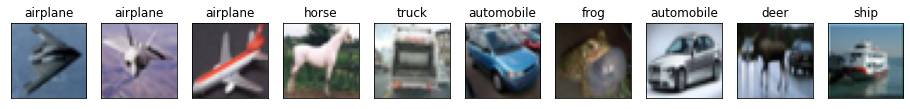

In [3]:
plt.figure(figsize=(16, 10))
n = 10

random_indices = np.random.choice(range(len(dataset_train)), size=n)

for i, idx in enumerate(random_indices):
    plt.subplot(1, n, i + 1)
    X, y = dataset_train[idx]
    plt.imshow(X.numpy().transpose(1, 2, 0))
    plt.title(dataset_train.classes[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

Заранее создадим даталоадеры:

In [4]:
batch_size = 500

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size)

## 1.2. Полносвязная сетка 

Соберём полносвязную сетку по аналогии с тем, что мы делали в прошлый раз:

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
!nvidia-smi

Wed May 12 18:04:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Вход: (3, 32, 32)
# Выход: (10,)
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
).to(device)
# Не забудьте перенести модель на device!

with torch.no_grad():
    y_pred = model(dataset_train[0][0].unsqueeze(0).to(device))
    assert y_pred.shape == (1, len(dataset_train.classes)), 'Модель должна выдавать по логиту для каждого класса'
    del y_pred
    assert next(model.parameters()).device.type == torch.device(device).type, 'Вы забыли перенести модель на device'

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

Кстати, заодно посмотрим на библиотеку `torchsummary`, позволяющую красиво печатать модель:

In [9]:
from torchsummary import summary

# на вход надо передать шейп входа модели, не считая размерности батча
summary(model, dataset_train[0][0].shape, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 128]         393,344
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 1.51
Estimated Total Size (MB): 1.54
----------------------------------------------------------------


Зафиксируем параметры обучения:

In [10]:
num_epochs = 20
learning_rate = 1e-3  # Кстати, это learning rate по умолчанию для Adam

Заведём `criterion`, `opt`...

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

Функция для обучения. Ничего необычного:

In [13]:
def train(model, criterion, opt, train_dataloader, valid_dataloader, num_epochs, device='cuda:0'):
    history = {'loss_train': [], 'loss_valid': [], 'accuracy_valid': [], 'lr': []}
    
    with tqdm(range(1, num_epochs + 1)) as progress_bar:
        for epoch in progress_bar:
            epoch_losses_train = []
            epoch_losses_valid = []
            epoch_correct_predictions_valid = []
            
            # Трейн
            for x_batch, y_batch in train_dataloader:
                # Переносим батч на GPU
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model(x_batch)  # делаем предсказания
                loss = criterion(y_pred, y_batch)  # считаем лосс
                
                epoch_losses_train.append(loss.item())
                assert np.isfinite(epoch_losses_train[-1])

                # Считаем градиенты и делаем шаг оптимизатора, не забыв обнулить градиенты
                opt.zero_grad()
                loss.backward()
                opt.step()

            with torch.no_grad():
                for x_batch, y_batch in valid_dataloader:
                    # Переносим батч на GPU
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)

                    y_pred = model(x_batch)  # делаем предсказания
                    loss = criterion(y_pred, y_batch)  # считаем лосс
                    
                    epoch_losses_valid.append(loss.item())
                    assert np.isfinite(epoch_losses_valid[-1])

                    batch_correct_predictions = torch.argmax(y_pred, dim=-1) == y_batch
                    epoch_correct_predictions_valid.extend(batch_correct_predictions.to('cpu').numpy().tolist())
                    
            history['loss_train'].append(np.mean(epoch_losses_train))
            history['loss_valid'].append(np.mean(epoch_losses_valid))
            history['accuracy_valid'].append(np.mean(epoch_correct_predictions_valid))
            history['lr'].append(opt.param_groups[0]['lr'])

            # выводим статистику
            stats = f'loss: {history["loss_valid"][-1]:.5f}, accuracy: {history["accuracy_valid"][-1]:.4f}'
            print(f'Epoch: {epoch}, {stats}')
            progress_bar.set_postfix_str(stats)
            
    return history

Вспомогательная функция, чтобы рисовать графики:

In [14]:
def plot_history(histories):
    plt.figure(figsize=(16, 10))

    for name, history in histories.items():
        train = plt.plot(history['loss_train'], label=f'{name} train')
        plt.plot(history['loss_valid'], color=train[0].get_color(), linestyle='--', label=f'{name} valid')

    plt.xlabel('Epochs')
    plt.ylabel('Log loss')
    plt.legend()
    plt.grid()

histories = {}

Учим бейзлайн:

In [15]:
histories['fc'] = train(model, criterion, opt, train_dataloader, valid_dataloader, num_epochs, device=device)

Epoch: 1, loss: 1.87449, accuracy: 0.3336
Epoch: 2, loss: 1.78092, accuracy: 0.3770
Epoch: 3, loss: 1.73398, accuracy: 0.3842
Epoch: 4, loss: 1.70294, accuracy: 0.4007
Epoch: 5, loss: 1.67727, accuracy: 0.4129
Epoch: 6, loss: 1.64887, accuracy: 0.4218
Epoch: 7, loss: 1.61495, accuracy: 0.4296
Epoch: 8, loss: 1.60428, accuracy: 0.4320
Epoch: 9, loss: 1.58458, accuracy: 0.4360
Epoch: 10, loss: 1.56963, accuracy: 0.4411
Epoch: 11, loss: 1.55127, accuracy: 0.4501
Epoch: 12, loss: 1.55667, accuracy: 0.4463
Epoch: 13, loss: 1.54382, accuracy: 0.4506
Epoch: 14, loss: 1.51770, accuracy: 0.4650
Epoch: 15, loss: 1.50607, accuracy: 0.4645
Epoch: 16, loss: 1.50107, accuracy: 0.4740
Epoch: 17, loss: 1.51300, accuracy: 0.4635
Epoch: 18, loss: 1.50145, accuracy: 0.4664
Epoch: 19, loss: 1.49767, accuracy: 0.4743
Epoch: 20, loss: 1.48693, accuracy: 0.4732



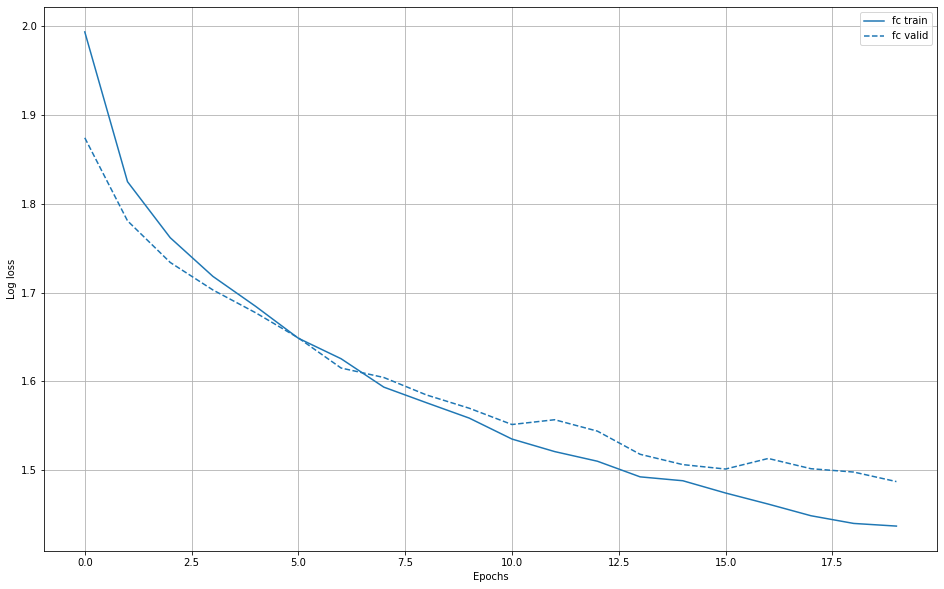

In [16]:
plot_history(histories)

## 1.3. Свёрточная сетка 

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) — Свёртка:
    - **`in_channels`**: число каналов на входе;
    - **`out_channels`**: число каналов на выходе; 
    - **`kernel_size`**: размер окна для свёртки;
    - **`padding`**: какой ширины будет каёмка из нулей по краям картинки перед непосредственно свёрткой (если хотите, чтобы свёртка не меняла размер картинки, ставьте `padding=(kernel_size - 1) // 2`)
* [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) — max pooling
    - **`kernel_size`**: размер скользящего окна
* [`nn.AvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) — average pooling
* [`nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.flatten.html) — разворачивает картинку в вектор 
* [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) — полносвязный слой (fully-connected layer)
* [`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) — функция активации. Естественно, можно выбрать любую другую


В модели, которую мы определим ниже, на вход будут тензоры размера `(B, 1, 32, 32)`, а на выходе `(B, 10)` — это будет вероятность того, что объект относится к конкретному классу. `B`, как обычно, означает размерность батча. 

Теперь давайте соберём свёрточную сеть наподобие LeNet-5: 

* Свёртка с $3$ каналами на входе (для цветного изображения), $32$ каналами на выходе, ядром $5 \times 5$ и `padding` таким, чтобы размер изображения не менялся
* ReLU
* Max-pooling с ядром $2 \times 2$ с шагом (strides) $2$ по обеим осям
* Свёртка с $16$ каналами на выходе, ядром $5 \times 5$ и `padding` таким, чтобы размер изображения не менялся
* ReLU
* Max-pooling с ядром $2 \times 2$ с шагом (strides) $2$ по обеим осям
* `Flatten`
* Три полносвязных слоя с $120$, $60$ и $10$ нейронами соответственно. Здесь вам нужно будет посчитать или посмотреть, какого размера тензоры будут получаться после `Flatten`

Это не то же самое, что оригинальный LeNet-5. Если вы заглянете в [оригинальную статью](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), то увидите там очень читабельное описание архитектуры, которая на современный взгляд выглядит странно.

Реализацию оригинальной архитектуры на PyTorch можно посмотреть, например, [тут](https://github.com/maorshutman/lenet5-pytorch).

In [18]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=5, padding=2),  # 32x32x32
    nn.ReLU(),
    nn.MaxPool2d(2),  # 32x16x16
    nn.Conv2d(32, 16, kernel_size=5, padding=2),  # 16x16x16
    nn.ReLU(),
    nn.MaxPool2d(2),  # 16x8x8
    nn.Flatten(),
    nn.Linear(16 * 8 * 8, 120),
    nn.ReLU(),
    nn.Linear(120, 60),
    nn.ReLU(),
    nn.Linear(60, 10)
).to(device)
# Не забудьте перенести модель на device!

with torch.no_grad():
    y_pred = model(dataset_train[0][0].unsqueeze(0).to(device))
    assert y_pred.shape == (1, len(dataset_train.classes)), 'Модель должна выдавать по логиту для каждого класса'
    del y_pred
    assert next(model.parameters()).device.type == torch.device(device).type, 'Вы забыли перенести модель на device'

model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1024, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=60, bias=True)
  (10): ReLU()
  (11): Linear(in_features=60, out_features=10, bias=True)
)

In [20]:
summary(model, dataset_train[0][0].shape, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]          12,816
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                  [-1, 120]         123,000
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 60]           7,260
             ReLU-11                   [-1, 60]               0
           Linear-12                   [-1, 10]             610
Total params: 146,118
Trainable params: 146,118
Non-trainable params: 0
-------------------------------

In [21]:
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
histories['conv'] = train(model, criterion, opt, train_dataloader, valid_dataloader, num_epochs, device=device)

Epoch: 1, loss: 1.67297, accuracy: 0.3955
Epoch: 2, loss: 1.50657, accuracy: 0.4605
Epoch: 3, loss: 1.39872, accuracy: 0.4984
Epoch: 4, loss: 1.35486, accuracy: 0.5088
Epoch: 5, loss: 1.32200, accuracy: 0.5213
Epoch: 6, loss: 1.30256, accuracy: 0.5427
Epoch: 7, loss: 1.24105, accuracy: 0.5579
Epoch: 8, loss: 1.26811, accuracy: 0.5471
Epoch: 9, loss: 1.17842, accuracy: 0.5829
Epoch: 10, loss: 1.14216, accuracy: 0.5908
Epoch: 11, loss: 1.17770, accuracy: 0.5874
Epoch: 12, loss: 1.10015, accuracy: 0.6069
Epoch: 13, loss: 1.10916, accuracy: 0.6111
Epoch: 14, loss: 1.08569, accuracy: 0.6183
Epoch: 15, loss: 1.05180, accuracy: 0.6293
Epoch: 16, loss: 1.02843, accuracy: 0.6371
Epoch: 17, loss: 1.03660, accuracy: 0.6328
Epoch: 18, loss: 1.02421, accuracy: 0.6426
Epoch: 19, loss: 1.03947, accuracy: 0.6295
Epoch: 20, loss: 0.97457, accuracy: 0.6578



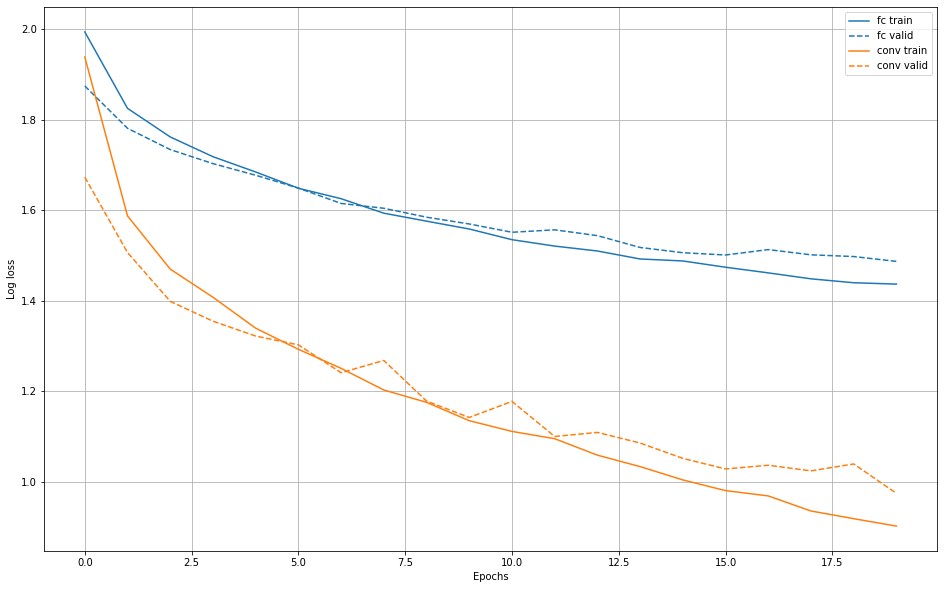

In [23]:
plot_history(histories)

Как видите, точность довольно сильно подскочила. Попробуйте поиграться числом параметров и слоёв так, чтобы их стало меньше, а качество сетки стало лучше. Попробуйте обучать нейросетку большее количество эпох.

In [ ]:
# Здесь могли быть ваши эксперименты

# 2. Готовые архитектуры

Здесь мы посмотрим на реализации готовых архитектур, о которых мы говорили на лекции, в библиотеке torchvision.

## 2.1. AlexNet

In [24]:
# можно указать pretrained=True, и тогда torchvision скачает готовые веса, обученные на ImageNet
model = torchvision.models.alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [25]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## 2.2. VGG

In [26]:
model = torchvision.models.vgg16()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

В этом месте давайте вспомним [ноутбук](https://github.com/dniku/neural_nets_dpo/blob/master/week01/pytorch_pretrained_model_demo.ipynb) с самого первого семинара. Там мы как раз использовали VGG-16!

## 2.3. GoogLeNet

In [28]:
# init_weights=False нужен из-за бага в scipy (попробуйте убрать этот параметр, и увидите предупреждение)
model = torchvision.models.googlenet(init_weights=False)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [29]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

## 2.4. ResNet

In [30]:
model = torchvision.models.resnet18(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# 3. Реализуем ResNet

Здесь мы руками изготовим модель, в точности повторяющую ResNet-18 из `torchvision.models` — настолько, что можно будет взять `state_dict` от одной модели и загрузить в другую. Этот процесс мы разделим на две части.

В первую очередь мы сделаем так называемый residual block: модуль, содержащий внутри себя skip connection. Мы его сделаем так, чтобы при проходе через него у тензора могли измениться размеры или количество каналов. Он выглядит так:

```
--> conv -> bn -> relu -> conv -> bn --> + --> relu -->
 |                                       ↑
 '--------->optionally downsample--------'
```

При этом:

* Все свёртки `conv` имеют kernel size 3x3 и padding=1
* Изменение количества каналов и страйды есть только в первой свёртке `conv`
* `downsample` — это последовательность из свёртки 1x1 (опционально со страйдами) и батчнорма
* Во всех свёртках не используется bias

In [33]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1) -> None:
        super(BasicBlock, self).__init__()

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        # x = nn.Sequential(self.conv1, ...)(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x = x + identity
        x = self.relu(x)
        return x

Теперь соберём саму модель. Она состоит из начала вида

```
conv -> bn -> relu -> maxpool
```

Затем 4 раза повторяется конструкция из серии `BasicBlock`. В ResNet-18 в каждой такой серии блоков 2.

```
layer1: BasicBlock(64, 64, stride=1) -> BasicBlock(64, 64, stride=1)
layer2: BasicBlock(64, 128, stride=2) -> BasicBlock(128, 128, stride=1)
layer3: BasicBlock(128, 256, stride=2) -> BasicBlock(256, 256, stride=1)
layer4: BasicBlock(256, 512, stride=2) -> BasicBlock(512, 512, stride=1)
```

Наконец, в конце результат усредняется по пространственным размерностям и применяется один полносвязный слой, чтобы сделать итоговое предсказание. Таким образом, ResNet-18 — это логистическая регрессия поверх свёрточных фичей.

In [37]:
class ResNet18(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        self.layer4 = self._make_layer(256, 512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Это усредняет активации по пространственным размерностям
        self.fc = nn.Linear(512, num_classes)

        # В реализации ResNet-18 из torchvision используется ещё хитрая инициализация весов.
        # Здесь мы это опускаем.

    @staticmethod
    def _make_layer(in_channels: int, out_channels: int, stride: int = 1) -> nn.Sequential:
        return nn.Sequential(
            BasicBlock(in_channels, out_channels, stride),
            BasicBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.squeeze(3).squeeze(2)
        x = self.fc(x)

        return x

resnet18 = ResNet18()
resnet18

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel

Ну и проверим, что она ведёт себя так же, как оригинал.

In [38]:
resnet18 = ResNet18()
tv_resnet18 = torchvision.models.resnet18()

tv_resnet18.load_state_dict(resnet18.state_dict())

x = torch.randn(1, 3, 224, 224)
torch.allclose(resnet18(x), tv_resnet18(x))

True

In [39]:
resnet18 = ResNet18()
tv_resnet18 = torchvision.models.resnet18()

resnet18.load_state_dict(tv_resnet18.state_dict())

x = torch.randn(1, 3, 224, 224)
torch.allclose(resnet18(x), tv_resnet18(x))

True

In [40]:
summary(torchvision.models.resnet152(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,